In [1]:
import numpy as np
x_train = np.load('MNIST_x_train.npy')
y_train = np.load('MNIST_y_train.npy')
print(y_train[0])


5


In [3]:
from torch.utils.data import Dataset, DataLoader
import torch

class MyDataset(Dataset):
    def __init__(self):
        self.x_input = np.load("MNIST_x_train.npy").astype(np.float32).reshape(-1, 28*28)

    def __len__(self):
        return len(self.x_input)

    def __getitem__(self, idx):
        return torch.cuda.FloatTensor(self.x_input[idx])

data_loader = DataLoader(MyDataset(), batch_size=1000, shuffle=True,generator=torch.Generator(device='cuda'))

In [ ]:
#data set
# __init__(self,path)
## x_train = np.load("MNIST_y_test.npy")
## y_train = pd.read_csv("dfdfd.csv")
# __len__(self) 
## return len(self.x_train)
# __get__(self,num)
## return y_train[num], one_hot_y[num]

#data loader
#dataloader = dataLoader(dataset,batch_size=32)

In [19]:
import torch
import numpy 
from torch.nn import MSELoss
from torch.optim import Adam

class VAE(torch.nn.Module):
    def __init__(self,dim_latent = 2):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,2*dim_latent),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim_latent,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,784),
            torch.nn.Sigmoid()
        )
        self.dim_latent = dim_latent
        self.optim_en = Adam(self.encoder.parameters(),lr=0.02)
        self.optim_de = Adam(self.decoder.parameters(),lr=0.02)
        self.loss_fn = MSELoss()

        self.num_epoch=400
        self.hist_loss = []
        self.hist_model = []

    def forward(self,x):
        x = self.encoder(x).view(-1,2,self.dim_latent)

        self.mu = x[:,0,:]
        self.log_var = x[:,1,:]
        epsilon = torch.randn_like(self.mu)

        sigma = torch.exp(self.log_var/2)

        self.z = self.mu+sigma*epsilon

        de = self.decoder(self.z)
        return de

    def train(self,data_loader):
        
        for epoch in range(1, 101):
            for x_input in data_loader:
                self.optim_en.zero_grad()
                self.optim_de.zero_grad()
                y_pred = self.forward(x_input)
                
                mse_loss = self.loss_fn(y_pred, x_input)
                kl_loss = -0.5*torch.sum(1+self.log_var-2*self.mu**2 - 2*torch.exp(self.log_var))
                loss = mse_loss+kl_loss
                loss.backward()
                self.optim_de.step()
                self.optim_en.step()
                print('hi')
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: loss = {loss.item()}")

    def visualize(self):
        pass
        

In [ ]:
x_input = torch.FloatTensor(x_train).flatten(1)
vae = VAE()
vae.train(data_loader)

In [12]:
vae =VAE()
vae.load_state_dict(torch.load("my_vae_trained.pth",map_location=torch.device('cpu')))


<All keys matched successfully>

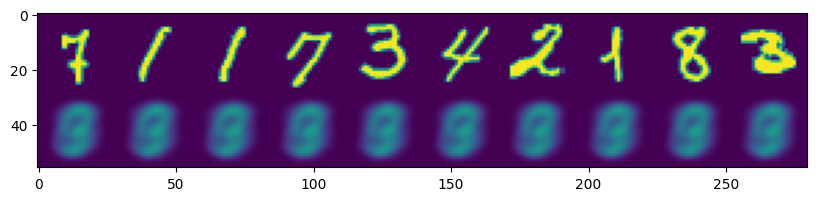

In [13]:
import matplotlib.pyplot as plt

def compare(model, n_samples = 20):
    x_np = np.load("MNIST_x_train.npy")
    x_np = x_np[np.random.choice(x_np.shape[0], n_samples)]
    y_pre = model.forward(torch.tensor(x_np, dtype=torch.float).flatten(start_dim=1)).detach().numpy()
    y_samples = y_pre.reshape(-1, 28, 28).transpose((1, 0, 2)).reshape(28, 28 * n_samples)
    x_samples = x_np.reshape(-1, 28, 28).transpose((1, 0, 2)).reshape(28, 28 * n_samples)

    plt.figure(figsize=(16, 2))
    plt.imshow(np.concatenate([x_samples, y_samples]))

compare(vae, 10)

In [ ]:
torch.save(ae.state_dict(), "my_ae_trained.pth")